In [52]:
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from fittingtask import FittingTask
import os
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
from matplotlib.lines import Line2D
homedir = os.path.expanduser('~')

In [3]:
datadir = f"{homedir}/uoedrive/data/IGRINS/"

In [40]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS/SDCK*_1f.spec.fits'))

fluxes = []
wls = []

for filename in filelist:
    wlname = filename.split('_1f')[0]+'.wave.fits'

    flux = fits.getdata(filename)
    wl = fits.getdata(wlname)

    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]

    #print(wl.shape)
    
    fluxes.append(flux)
    wls.append(wl)
dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
eobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
fobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
wfobs0 = 1./eobs0**2   # make noise spectrum
#ind = np.where(np.isinf(wfobs0)) # set infinite values in noise spectrum to NaNs
#wfobs0[ind] = np.nan
wind = np.isinf(wfobs0)  # remove points with infinite values
wfobs0[wind] = 0.

# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

/var/folders/0q/dylv__nn23gfz6mtsk9ys_6r0000gn/T/ipykernel_15442/762451351.py:29: RuntimeWarning: divide by zero encountered in divide
  wfobs0 = 1./eobs0**2   # make noise spectrum


In [10]:
wls.shape

(56, 26, 1848)

In [13]:
jj=3
pix=0
wls[:,jj,pix]


array([2.38706132, 2.38706132, 2.38706103, 2.38706103, 2.38706103,
       2.38706103, 2.38706103, 2.38706103, 2.38706075, 2.38706075,
       2.38706075, 2.38706075, 2.38706075, 2.38706075, 2.38706046,
       2.38706046, 2.38706046, 2.38706046, 2.38706046, 2.38706018,
       2.38706018, 2.38706018, 2.38706018, 2.38706018, 2.38706018,
       2.3870599 , 2.3870599 , 2.3870599 , 2.3870599 , 2.3870599 ,
       2.38705961, 2.38705961, 2.38705961, 2.38705961, 2.38705933,
       2.38705933, 2.38705933, 2.38705933, 2.38705933, 2.38705933,
       2.38705904, 2.38705904, 2.38705904, 2.38705904, 2.38705904,
       2.38705904, 2.38705876, 2.38705876, 2.38705876, 2.38705876,
       2.38705876, 2.38705876, 2.38705876, 2.38705876, 2.38705847,
       2.38705847])

In [30]:
chipmods = fits.getdata("IGRINS_W1049B_chipmods.fits")
chiplams = fits.getdata("IGRINS_W1049B_chiplams.fits")

In [16]:
results = Table.read('IGRINS_W1049B_fitting_results.txt', format='ascii')

In [17]:
results

order,obs,chisq,vsini,limbdark,rv
int64,int64,float64,float64,float64,float64
0,0,5928.0860075897945,33.67280657720654,0.012912690760169085,0.0002031922404098955
0,1,5928.0860075897945,33.67280657720654,0.012912690760169085,0.0002031922404098955
0,2,5913.696655734798,34.757861286752586,0.23304778994980901,6.932014605309282e-05
0,3,5913.696655734798,34.757861286752586,0.23304778994980901,6.932014605309282e-05
0,4,5913.696655734798,34.757861286752586,0.23304778994980901,6.932014605309282e-05
0,5,5913.696655734798,34.757861286752586,0.23304778994980901,6.932014605309282e-05
0,6,5913.696655734798,34.757861286752586,0.23304778994980901,6.932014605309282e-05
0,7,5913.696655734798,34.757861286752586,0.23304778994980901,6.932014605309282e-05
0,8,5945.391824396466,32.94768796203516,0.3023841661816704,0.00010889768547494379


Text(0.5, 1.0, 'chi^2 map')

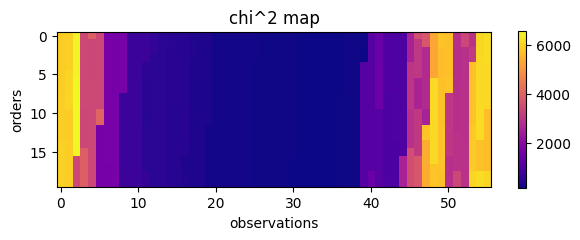

In [64]:
chisq = results['chisq'].reshape((56, 20))
plt.figure(figsize=(6,2))
plt.imshow(chisq.T, cmap='plasma')
plt.colorbar()
plt.tight_layout()
plt.xlabel("observations")
plt.ylabel("orders")
plt.title("chi^2 map")

Text(0.5, 1.0, 'vsini map')

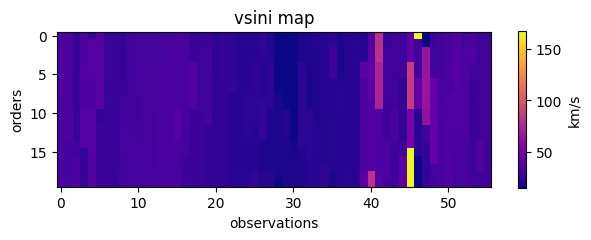

In [65]:
vsini = results['vsini'].reshape((56, 20))
plt.figure(figsize=(6,2))
plt.imshow(vsini.T, cmap='plasma')
plt.colorbar().set_label("km/s")
plt.tight_layout()
plt.xlabel("observations")
plt.ylabel("orders")
plt.title("vsini map")

Text(0.5, 1.0, 'rv map')

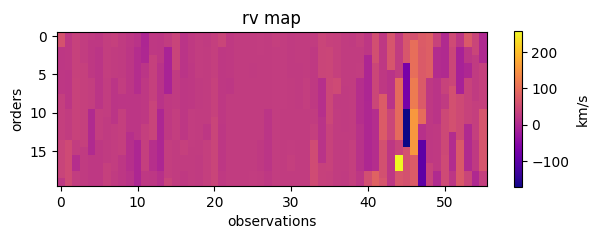

In [66]:
rv = results['rv'].reshape((56, 20)) * 2.99e5
plt.figure(figsize=(6,2))
plt.imshow(rv.T, cmap='plasma')
plt.colorbar().set_label("km/s")
plt.tight_layout()
plt.xlabel("observations")
plt.ylabel("orders")
plt.title("rv map")

In [47]:
chipmods_mean = np.median(chipmods, axis=0)
chiplams_mean = np.median(chiplams, axis=0)
fobs_mean = fobs0[:20]
wobs_mean = np.median(wls, axis=0)[:20]

Text(0, 0.5, 'flux')

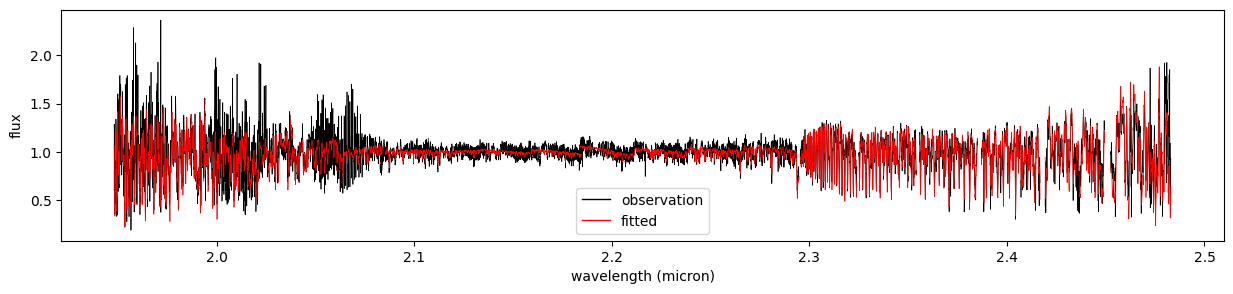

In [59]:
plt.figure(figsize=(15,3))
for jj in range(20):
    plt.plot(wobs_mean[jj,:], fobs_mean[jj,:], linewidth=0.5, color="black", label="observation")
    plt.plot(chiplams_mean[jj,:], chipmods_mean[jj,:], linewidth=0.5, color="r", label="fitted")
custom_lines = [Line2D([0], [0], color="black", lw=1),
                Line2D([0], [0], color="r", lw=1)]
plt.legend(custom_lines, ["observation", "fitted"])
plt.xlabel("wavelength (micron)")
plt.ylabel("flux")